<a href="https://colab.research.google.com/github/TheNobody-12/Facial-Emotion-Detection/blob/main/emotion_recognition_with_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d msambare/fer2013

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          10752        325  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           2926         81  1.0              
harshsingh2209/tesla-stock-pricing-20172022                    TESLA stock pricing (2017-2022)                      28KB  2022-09-18 14:56:29            490         23  1.0              
thedevastator/airplane-crashes-and-fatalities                  Ai

In [3]:
! unzip /content/fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [4]:
%pip install scikit-image
# %pip install skimage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = '../content/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../content/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [9]:
test_dataset = test_datagen.flow_from_directory(directory = '../content/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [10]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58900480/58889256 [==============================] - 2s 0us/step


In [11]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [12]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [13]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [14]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        # f1_score,
]

In [16]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/100
359/359 [==============================] - 54s 96ms/step - loss: 1.9199 - accuracy: 0.8556 - precision: 0.2543 - recall: 0.0057 - auc: 0.6072 - val_loss: 1.8118 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6531 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 33s 92ms/step - loss: 1.8195 - accuracy: 0.8567 - precision: 0.3285 - recall: 0.0030 - auc: 0.6480 - val_loss: 1.7778 - val_accuracy: 0.8573 - val_precision: 0.8571 - val_recall: 0.0010 - val_auc: 0.6721 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 35s 96ms/step - loss: 1.7603 - accuracy: 0.8571 - precision: 0.4932 - recall: 0.0142 - auc: 0.6857 - val_loss: 1.7947 - val_accuracy: 0.8587 - val_precision: 0.5737 - val_recall: 0.0434 - val_auc: 0.6676 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 33s 91ms/step - loss: 1.7403 - accuracy: 0.8578 - precision: 0.5581 - recall: 0.0209 - auc: 0.6944 - val_loss: 1.8377 - v

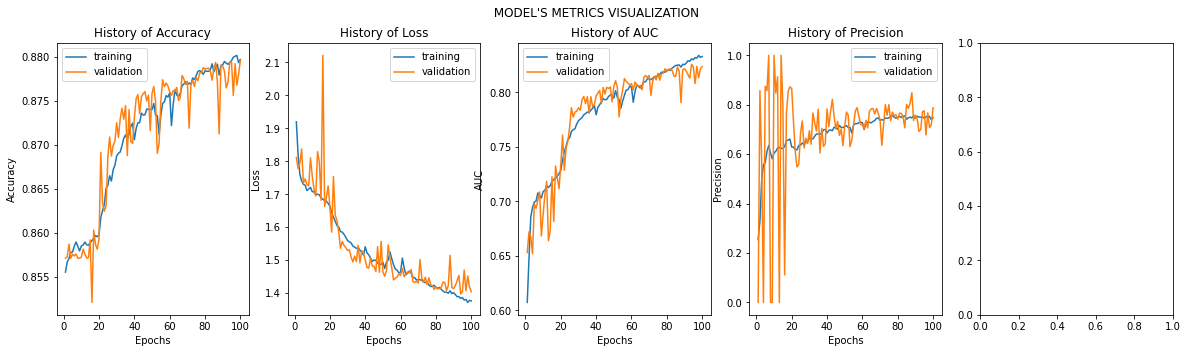

In [20]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    # ax5.plot(range(1, len(f1) + 1), f1)
    # ax5.plot(range(1, len(val_f1) + 1), val_f1)
    # ax5.set_title('History of F1-score')
    # ax5.set_xlabel('Epochs')
    # ax5.set_ylabel('F1 score')
    # ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              )

In [21]:
model.save("/content/drive/MyDrive/FaceData/vgg16EMD1.h5")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


sad
/content/test/sad
(48, 48)


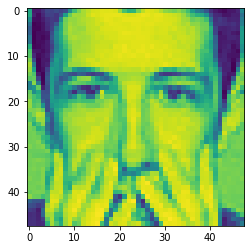

In [ ]:
# take random image from Directory
import random
import os
import cv2
DIRECTORY = r"/content/test"
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
IMG_SIZE = 48
# print random index from CATEGORIES
RandomC =random.choice(CATEGORIES)
print(RandomC)
# print random image from CATEGORIES
folder = os.path.join(DIRECTORY,RandomC)
print(folder)
img = random.choice(os.listdir(folder))
img_path = os.path.join(folder,img)
img_arr = plt.imread(img_path) 
img_arr = cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE))
plt.imshow(img_arr)
print(img_arr.shape)
plt.show()  

In [ ]:
img_arr = img_arr.reshape(48, 48)
# img_arr.shape
img_arr = model.predict(img_arr)

ValueError: ignored